In [1]:
import os
import torch
from trainer import Trainer

from Preprocessing import (
    filter_collate_fn,
    generate_file_path,
    get_train_transform,
    get_validation_transform
)

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    SmartCacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

from monai.losses import DiceCELoss

from monai.networks.nets import SwinUNETR
from map_to_binary import class_map_5_parts
from monai.data.utils import pad_list_data_collate


MONAI version: 1.2.dev2313
Numpy version: 1.23.5
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 331437dfce075b4fa5785016ad4e7f8c7c77ad21
MONAI __file__: D:\Arash\Semester2\DeepLearning\FinalProject\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.7.1
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.27.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
task_name = 'muscles'
val_transforms = get_validation_transform()
train_transforms = get_train_transform(num_samples=4)

# Load Dataset

In [3]:
root_dataset = 'DatasetCombined'
label_name = f'labels_task_{task_name}'

In [4]:
file_list_val = generate_file_path(root_path=f'{root_dataset}/val', label_name=label_name)
file_list_train = generate_file_path(root_path=f'{root_dataset}/train', label_name=label_name)

KeyboardInterrupt: 

In [4]:
train_ds = PersistentDataset(
    data=file_list_train,
    transform=train_transforms,
    cache_dir=f'C:/Training/train_{task_name}'
)

train_loader = ThreadDataLoader(train_ds, batch_size=1, shuffle=True,
                                collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96))
                               )

In [5]:
val_ds = PersistentDataset(
    data=file_list_val,
    transform=val_transforms,
    cache_dir=f'val_{task_name}'
#     cache_dir='C:/Training/val'
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=0,
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [4]:
num_of_classes = len(class_map_5_parts[f'class_map_part_{task_name}']) + 1
num_of_classes

22

# Model

In [5]:
root_dir = 'Model'
model_folder = os.path.join(root_dir, f'SwinTransformer_{task_name}')
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

In [6]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=num_of_classes,
    feature_size=48,
#     drop_rate=0.25,
    use_checkpoint=True,
)

In [7]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1, lambda_ce=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [8]:
swin_trainer = Trainer(
    model=model,
    max_epoch=1000,
    optimizer=optimizer,
    num_samples=4,
    loss_function=loss_function,
    model_root_path=model_folder,
    number_of_classes=num_of_classes,
    )
swin_trainer.load_weights()

In [11]:
torch.backends.cudnn.benchmark = True
swin_trainer.train(train_loader, val_loader)

Validate (loss=1.14899): 100%|█████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.41s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.09714753180742264 Current Avg. Dice: 0.09714753180742264


Validate (loss=0.95409): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.30171725153923035 Current Avg. Dice: 0.30171725153923035


Validate (loss=0.87043): 100%|█████████████████████████████████████████████████████████| 50/50 [02:40<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5167964696884155 Current Avg. Dice: 0.5167964696884155


Validate (loss=0.81177): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6441749334335327 Current Avg. Dice: 0.6441749334335327


Validate (loss=0.74676): 100%|█████████████████████████████████████████████████████████| 50/50 [02:40<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7150810360908508 Current Avg. Dice: 0.7150810360908508


Validate (loss=0.69191): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7863183617591858 Current Avg. Dice: 0.7863183617591858


Validate (loss=0.66923): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8021641373634338 Current Avg. Dice: 0.8021641373634338


Validate (loss=0.64895): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8178707957267761 Current Avg. Dice: 0.8178707957267761


Validate (loss=0.62126): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8315128087997437 Current Avg. Dice: 0.8315128087997437


Validate (loss=0.63082): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.5166593566536903, current_loss: 0.5255587643384934
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8315128087997437 Current Avg. Dice: 0.8279902935028076


Validate (loss=0.61109): 100%|█████████████████████████████████████████████████████████| 50/50 [02:44<00:00,  3.30s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8476310968399048 Current Avg. Dice: 0.8476310968399048


Validate (loss=0.60735): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8586455583572388 Current Avg. Dice: 0.8586455583572388


Validate (loss=0.59784): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.4896298108994961, current_loss: 0.49643896877765653
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8586455583572388 Current Avg. Dice: 0.8487474322319031


Validate (loss=0.59546): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8586455583572388 Current Avg. Dice: 0.8520205616950989


Validate (loss=0.60261): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.48799468457698825, current_loss: 0.49129825115203857
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8586455583572388 Current Avg. Dice: 0.8545224070549011


Validate (loss=0.57968): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8706836104393005 Current Avg. Dice: 0.8706836104393005


Validate (loss=0.59978): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.47129529729485514, current_loss: 0.47966864943504334
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8706836104393005 Current Avg. Dice: 0.8681338429450989


Validate (loss=0.59232): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Early Stopping patience: 2, best loss: 0.47129529729485514, current_loss: 0.47269603848457337
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8719258308410645 Current Avg. Dice: 0.8719258308410645


Validate (loss=0.57199): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8857306838035583 Current Avg. Dice: 0.8857306838035583


Validate (loss=0.56210): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.24s/it]


Early Stopping patience: 1, best loss: 0.4602439287304878, current_loss: 0.46200299337506295
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8872852325439453 Current Avg. Dice: 0.8872852325439453


Validate (loss=0.56828): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8872852325439453 Current Avg. Dice: 0.8801433444023132


Validate (loss=0.56300): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.459165820479393, current_loss: 0.46109705567359927
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.888379693031311 Current Avg. Dice: 0.888379693031311


Validate (loss=0.55999): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8909835815429688 Current Avg. Dice: 0.8909835815429688


Validate (loss=0.55535): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8909835815429688 Current Avg. Dice: 0.888610303401947


Validate (loss=0.56370): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8909835815429688 Current Avg. Dice: 0.8862614631652832


Validate (loss=0.55860): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Early Stopping patience: 1, best loss: 0.4509825228154659, current_loss: 0.4505674347281456
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8941763043403625 Current Avg. Dice: 0.8941763043403625


Validate (loss=0.55971): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8941763043403625 Current Avg. Dice: 0.8917784094810486


Validate (loss=0.55755): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.24s/it]


Early Stopping patience: 1, best loss: 0.4480428037047386, current_loss: 0.45007006973028185
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8941763043403625 Current Avg. Dice: 0.886274516582489


Validate (loss=0.55086): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.26s/it]


Early Stopping patience: 2, best loss: 0.4480428037047386, current_loss: 0.45050801552832126
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8965501189231873 Current Avg. Dice: 0.8965501189231873


Validate (loss=0.57205): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 3, best loss: 0.4480428037047386, current_loss: 0.4574079279601574
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8965501189231873 Current Avg. Dice: 0.8777433037757874


Validate (loss=0.54378): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8997511267662048 Current Avg. Dice: 0.8997511267662048


Validate (loss=0.54831): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Early Stopping patience: 1, best loss: 0.44186190105974676, current_loss: 0.45144087113440035
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8997511267662048 Current Avg. Dice: 0.8907964825630188


Validate (loss=0.54625): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9069758653640747 Current Avg. Dice: 0.9069758653640747


Validate (loss=0.54453): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 1, best loss: 0.44041737519204616, current_loss: 0.44010797671973706
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9069758653640747 Current Avg. Dice: 0.903048574924469


Validate (loss=0.54664): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 2, best loss: 0.44041737519204616, current_loss: 0.4528277134895325
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9069758653640747 Current Avg. Dice: 0.8947198987007141


Validate (loss=0.54366): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9069758653640747 Current Avg. Dice: 0.9036993384361267


Validate (loss=0.53973): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9122926592826843 Current Avg. Dice: 0.9122926592826843


Validate (loss=0.54098): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.4334548520296812, current_loss: 0.4362006738781929
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9122926592826843 Current Avg. Dice: 0.9031996726989746


Validate (loss=0.53831): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Early Stopping patience: 2, best loss: 0.4334548520296812, current_loss: 0.43747152186930177
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9122926592826843 Current Avg. Dice: 0.902640700340271


Validate (loss=0.54989): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Early Stopping patience: 3, best loss: 0.4334548520296812, current_loss: 0.43640322037041185
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9122926592826843 Current Avg. Dice: 0.9089027643203735


Validate (loss=0.54024): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Epoch 00041: reducing learning rate of group 0 to 2.5000e-05.
Early Stopping patience: 4, best loss: 0.4334548520296812, current_loss: 0.4355221552401781
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9122926592826843 Current Avg. Dice: 0.9103712439537048


Validate (loss=0.53528): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9194896221160889 Current Avg. Dice: 0.9194896221160889


Validate (loss=0.53288): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9198123216629028 Current Avg. Dice: 0.9198123216629028


Validate (loss=0.53335): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.4254387536644936, current_loss: 0.4251178942620754
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9198123216629028 Current Avg. Dice: 0.9181300401687622


Validate (loss=0.53459): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9198123216629028 Current Avg. Dice: 0.9187248349189758


Validate (loss=0.53107): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Early Stopping patience: 1, best loss: 0.42411425612866877, current_loss: 0.42377580039203167
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9204964637756348 Current Avg. Dice: 0.9204964637756348


Validate (loss=0.53204): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.9231131076812744


Validate (loss=0.53132): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.22s/it]


Early Stopping patience: 1, best loss: 0.422986426204443, current_loss: 0.4228514049947262
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.919085681438446


Validate (loss=0.53280): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.26s/it]


Early Stopping patience: 2, best loss: 0.422986426204443, current_loss: 0.42270643018186094
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.9187152981758118


Validate (loss=0.53180): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 3, best loss: 0.422986426204443, current_loss: 0.4231237816810608
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.9178793430328369


Validate (loss=0.53070): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.9228465557098389


Validate (loss=0.53298): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 1, best loss: 0.42168589025735853, current_loss: 0.42370984800159933
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.9168151617050171


Validate (loss=0.53100): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 2, best loss: 0.42168589025735853, current_loss: 0.42264095060527324
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9231131076812744 Current Avg. Dice: 0.9183632135391235


Validate (loss=0.52984): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.26s/it]


Early Stopping patience: 3, best loss: 0.42168589025735853, current_loss: 0.4211895895749331
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9238883256912231


Validate (loss=0.53048): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Early Stopping patience: 4, best loss: 0.42168589025735853, current_loss: 0.4210436098277569
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9205367565155029


Validate (loss=0.53056): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]


Early Stopping patience: 5, best loss: 0.42168589025735853, current_loss: 0.42121920481324193
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9211235046386719


Validate (loss=0.53105): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 6, best loss: 0.42168589025735853, current_loss: 0.42104178048670293
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9177916049957275


Validate (loss=0.53004): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.92108553647995


Validate (loss=0.53302): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.42039848029613497, current_loss: 0.4223322057723999
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.916269838809967


Validate (loss=0.53112): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 2, best loss: 0.42039848029613497, current_loss: 0.42089120447635653
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9228436350822449


Validate (loss=0.52943): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 3, best loss: 0.42039848029613497, current_loss: 0.41943728081882
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9222506880760193


Validate (loss=0.53010): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Early Stopping patience: 4, best loss: 0.42039848029613497, current_loss: 0.4217836432158947
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9213699102401733


Validate (loss=0.52931): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 5, best loss: 0.42039848029613497, current_loss: 0.4198582915216684
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9238883256912231 Current Avg. Dice: 0.9226315021514893


Validate (loss=0.52877): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9265490770339966 Current Avg. Dice: 0.9265490770339966


Validate (loss=0.52889): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]


Early Stopping patience: 1, best loss: 0.41804070085287093, current_loss: 0.41775745525956154
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.928510844707489


Validate (loss=0.52971): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]


Early Stopping patience: 2, best loss: 0.41804070085287093, current_loss: 0.4195054421573877
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9230915307998657


Validate (loss=0.52974): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 3, best loss: 0.41804070085287093, current_loss: 0.4187193502485752
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.926774263381958


Validate (loss=0.52804): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Early Stopping patience: 4, best loss: 0.41804070085287093, current_loss: 0.4178958769142628
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9267098903656006


Validate (loss=0.52769): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 5, best loss: 0.41804070085287093, current_loss: 0.417449401691556
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9263697862625122


Validate (loss=0.52865): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 6, best loss: 0.41804070085287093, current_loss: 0.4181742599606514
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9253952503204346


Validate (loss=0.52936): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.24s/it]


Early Stopping patience: 7, best loss: 0.41804070085287093, current_loss: 0.4194840294867754
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9245223999023438


Validate (loss=0.53105): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 8, best loss: 0.41804070085287093, current_loss: 0.41978326737880706
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9249545335769653


Validate (loss=0.52908): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Epoch 00073: reducing learning rate of group 0 to 6.2500e-06.
Early Stopping patience: 9, best loss: 0.41804070085287093, current_loss: 0.418322731629014
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9225622415542603


Validate (loss=0.52702): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9261771440505981


Validate (loss=0.52687): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 1, best loss: 0.4168455392867327, current_loss: 0.41672961696982386
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.928510844707489 Current Avg. Dice: 0.9263591170310974


Validate (loss=0.52700): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9288891553878784


Validate (loss=0.52690): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Early Stopping patience: 1, best loss: 0.4158307248353958, current_loss: 0.4161487165093422
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9288462996482849


Validate (loss=0.52650): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]


Early Stopping patience: 2, best loss: 0.4158307248353958, current_loss: 0.41569420248270034
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9279739856719971


Validate (loss=0.52761): 100%|█████████████████████████████████████████████████████████| 50/50 [02:40<00:00,  3.22s/it]


Early Stopping patience: 3, best loss: 0.4158307248353958, current_loss: 0.4169538664072752
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9244279265403748


Validate (loss=0.52747): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 4, best loss: 0.4158307248353958, current_loss: 0.4163897228240967
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9251040816307068


Validate (loss=0.52689): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


Early Stopping patience: 5, best loss: 0.4158307248353958, current_loss: 0.41605156503617763
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.927227795124054


Validate (loss=0.52671): 100%|█████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Epoch 00082: reducing learning rate of group 0 to 1.5625e-06.
Early Stopping patience: 6, best loss: 0.4158307248353958, current_loss: 0.41570407316088676
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9281065464019775


Validate (loss=0.52712): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 7, best loss: 0.4158307248353958, current_loss: 0.41600507237017154
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9253808856010437


Validate (loss=0.52671): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 8, best loss: 0.4158307248353958, current_loss: 0.415686376914382
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9266483783721924


Validate (loss=0.52673): 100%|█████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]


Early Stopping patience: 9, best loss: 0.4158307248353958, current_loss: 0.41559553243219854
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9264434576034546


Validate (loss=0.52663): 100%|█████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.26s/it]

Early Stopping patience: 10, best loss: 0.4158307248353958, current_loss: 0.4153877253830433
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9288891553878784 Current Avg. Dice: 0.9268079996109009


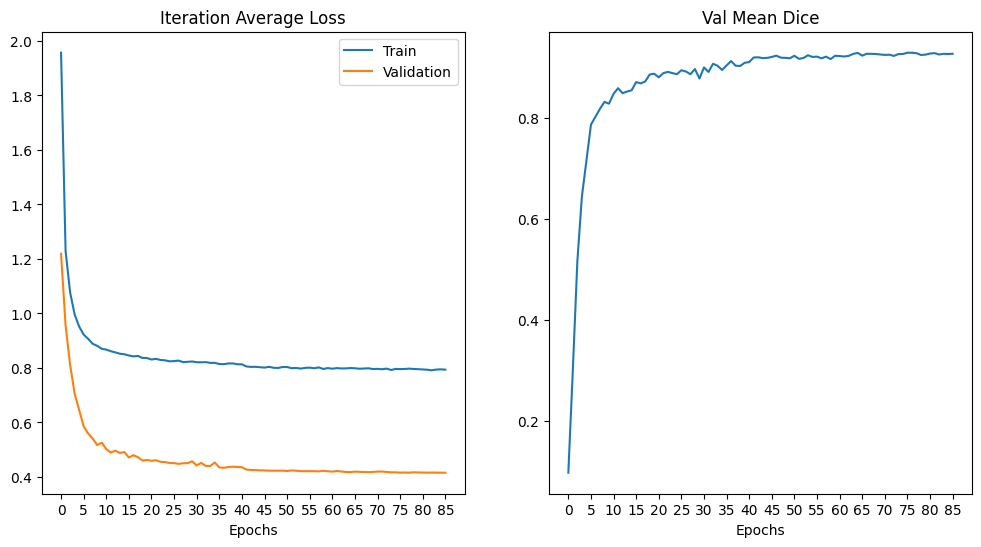

In [12]:
swin_trainer.plot_train_info()

In [9]:
file_list_test = generate_file_path(root_path=f'{root_dataset}/test', label_name=label_name)
test_ds = PersistentDataset(
    data=file_list_test,
    transform=val_transforms,
    cache_dir=f'test_{task_name}'
#     cache_dir='C:/Training/val'
)

test_loader = DataLoader(test_ds, num_workers=0, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [10]:
torch.cuda.empty_cache()

In [11]:
torch.cuda.empty_cache()
swin_trainer.test_new(test_loader)

Test:   0%|                                                                                     | 0/65 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None
invalid value encountered in double_scalars
torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
Test (loss=0.29084): 100%|█████████████████████████████████████████████████████████████| 65/65 [14:11<00:00, 13.10s/it]


([0.7892915089163011,
  0.7155436440143409,
  0.801708127700061,
  0.8178006652919346,
  0.8541907461971645,
  0.8690073566620362,
  0.8947272261814334,
  0.9171287301720974,
  0.9597867075571912,
  0.960381136668014,
  0.9313340697330506,
  0.9678918204167608,
  0.968088302696588,
  0.9612693448296317,
  0.9623796915508464,
  0.9347848659634597,
  0.9210235343793775,
  0.9633308268585071,
  0.9559121305693205,
  0.8645828944349028,
  0.9263425864996758],
 [36.247193804242954,
  34.82570689137403,
  35.5880052931754,
  33.4537296007778,
  31.032287246208963,
  28.229830567442033,
  23.467688439182695,
  21.394159016116923,
  14.497348150861203,
  14.503610775237332,
  19.936558891423818,
  2.0612076403060606,
  2.462945872621904,
  1.7354776501021556,
  1.4784949965346283,
  2.490849676193703,
  14.342396519276402,
  2.575942576120985,
  6.9620293100707915,
  26.121102789152317,
  14.69262528846748],
 [0.8055631805866157,
  0.8424794276296789,
  0.8250032191714339,
  0.8496241492081366

In [ ]:
for t in train_loader:
    if t['label'].max() == 0:
        print(t['label'].min(), t['label'].max() == 0)
    break